In [3]:
data_dir="/home/cadel/data/deduce/Bej04/homology"

In [2]:
import os
import pandas as pd
import seaborn as sns
from Bio import SeqIO
import constants
sns.set_context(constants.sns_context)
sns.set_style(constants.sns_style)

In [2]:
import re
import datetime

def parse_time_v_output(err):
    wall_s = re.findall("Elapsed \(wall clock\) time \(h:mm:ss or m:ss\): (.*)", err)[0]
    min_s, rest_s = wall_s.split(":")
    seconds_s, ms_s = rest_s.split(".")
    walltime = float(min_s) * 60 + float(seconds_s) + (float(ms_s) * 10 / 1000)

    max_rss_kb = float(re.findall("Maximum resident set size \(kbytes\): (.*)", err)[0])
    
    n_uces = int(re.findall("save (\d+) UCEs in fasta format", err)[0])

    return {"walltime_seconds": walltime, "max_mem_kb": max_rss_kb, "n_uces": n_uces}

In [3]:
import tempfile
import os
import shutil
import subprocess

DEFAULT_PARAMS = [
    "--uce-max-occurrences", "10000",
    "--uce-min-length", "200",
    "--core-kmer-size", "50",
    "--mapper", "minimap",
    "--output-format", "fasta",
    "--debug",
    "--threads", "16",
    "--reference", "hg16",
    "--skip-core-kmer-identification"
]

def run_deduce(params, wd):
    try:
        p = subprocess.run(
            ["/usr/bin/time", "-v", "/home/cadel/.local/bin/deduce", "find"] + params + [wd],
            check=True,
            capture_output=True
        )

        output = parse_time_v_output(p.stderr.decode("utf-8"))
    except subprocess.CalledProcessError as e:
        print(e.stderr)
        raise Exception("Failed")
        
    return output

# Validating the UCEs found actually exist

In [4]:
from Bio import SeqIO
import pysam
import more_itertools

BAM_CMATCH = 0
BAM_CINS = 1
BAM_CDEL = 2
BAM_CREF_SKIP = 3
BAM_CSOFT_CLIP = 4
BAM_CHARD_CLIP = 4
BAM_CPAD = 6
BAM_CEQUAL = 7
BAM_CDIFF = 8
BAM_CBACK = 9

def count_mismatches(
    ops,
    sequence_length,
):
    matches = 0

    for op, count in ops:
        if op == BAM_CMATCH or op == BAM_CEQUAL:
            matches += count
        
        if op == BAM_CDEL:
            matches -= count

    return sequence_length - matches

def reverse_complement(seq: str) -> str:
    m = {"A": "T", "T": "A", "G": "C", "C": "G"}
    return seq.translate(seq.maketrans(m))[::-1]  # type: ignore
def hamming(x: str, y: str) -> int:
    assert len(x) == len(y)
    same = 0
    for a, b in zip(x, y):
        if a == b:
            same += 1
    return same

def calculate_homology(ref: str, seq: str) -> float:
    long = ref if len(ref) > len(seq) else seq 
    short = seq if len(ref) > len(seq) else ref
    
    return (
            max((max(hamming(subseq, short),hamming(subseq, reverse_complement(short))) for subseq in more_itertools.windowed(long, n=len(short), step=1)),
        )
        / float(len(short))
    )

def validate_inexact_uces(homology = 90):
    uces = [
        x for x in SeqIO.parse(f"/home/cadel/data/deduce/Bej04/homology/results/50bp_extragap5_sl10000/{homology}.deduce.fa", "fasta")
    ]
    
    uce_seqs = {x.id: str(x.seq) for x in uces}
    
    sam_files = [
        f"/home/cadel/data/deduce/Bej04/homology/results/50bp_extragap5_sl10000/{homology}.deduce.fa.hg16.sam",
        f"/home/cadel/data/deduce/Bej04/homology/results/50bp_extragap5_sl10000/{homology}.deduce.fa.mm3.sam",
        f"/home/cadel/data/deduce/Bej04/homology/results/50bp_extragap5_sl10000/{homology}.deduce.fa.rn3.sam",        
    ]
    
    for file in sam_files:
        print(homology, file)
        best_homology = {
            x.id: 0 for x in uces
        }

        af = pysam.AlignmentFile(file, "r")

        for aln in af.fetch():
            uce_id = aln.query_name

            calc_homology = calculate_homology(aln.get_reference_sequence(), uce_seqs[uce_id])

            if calc_homology > best_homology[uce_id]:
                best_homology[uce_id] = calc_homology

        failed_threshold = {x:h for x,h in best_homology.items() if h < homology/100}
        if len(failed_threshold) > 0:
            print("Failed", homology, file, failed_threshold)

for h in range(90,101,1):
    validate_inexact_uces(h)


90 /home/cadel/data/deduce/Bej04/homology/results/50bp_extragap5_sl10000/90.deduce.fa.hg16.sam
90 /home/cadel/data/deduce/Bej04/homology/results/50bp_extragap5_sl10000/90.deduce.fa.mm3.sam
90 /home/cadel/data/deduce/Bej04/homology/results/50bp_extragap5_sl10000/90.deduce.fa.rn3.sam
91 /home/cadel/data/deduce/Bej04/homology/results/50bp_extragap5_sl10000/91.deduce.fa.hg16.sam
91 /home/cadel/data/deduce/Bej04/homology/results/50bp_extragap5_sl10000/91.deduce.fa.mm3.sam
91 /home/cadel/data/deduce/Bej04/homology/results/50bp_extragap5_sl10000/91.deduce.fa.rn3.sam
Failed 91 /home/cadel/data/deduce/Bej04/homology/results/50bp_extragap5_sl10000/91.deduce.fa.rn3.sam {'1300': 0.9014778325123153}
92 /home/cadel/data/deduce/Bej04/homology/results/50bp_extragap5_sl10000/92.deduce.fa.hg16.sam
Failed 92 /home/cadel/data/deduce/Bej04/homology/results/50bp_extragap5_sl10000/92.deduce.fa.hg16.sam {'298': 0.9166666666666666, '1185': 0.9181034482758621}
92 /home/cadel/data/deduce/Bej04/homology/results/5

# Number of UCEs vs. min. homology

Core kmer length: 50bp
Max. extra gap: 5bp
Max. core kmer mismatches: 0
Secondary mapping limit: 10000

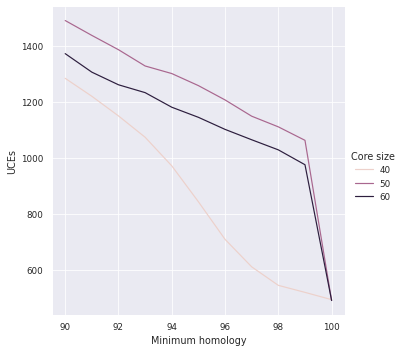

In [8]:


def get_basic_homology_data():
    seqs = []
    for core_size in [40, 50, 60]:
        for homology in range(90,101,1):
            seqs.append({"Core size": core_size, "homology": homology, "seqs": [x for x in SeqIO.parse(os.path.join(data_dir, "results", f"{core_size}bp_extragap5_sl10000", str(homology) + ".deduce.fa"), "fasta")]})

    for s in seqs:
        s["count"] = len(s["seqs"])

    df = pd.DataFrame().from_records(seqs)
    
    return df

h_plot = sns.relplot(data=get_basic_homology_data(), x="homology", y="count", hue="Core size", kind="line")
h_plot.set_axis_labels("Minimum homology", "UCEs", )
h_plot.savefig(os.path.join(constants.image_out_dir, "homology_vs_core_kmer_size.pdf"))


# Influence of various parameters on inexact homology UCEs

In [5]:
parameter_space = pd.read_csv("/home/cadel/data/deduce/performance/homology_parameter_space.csv", names=["Core kmer size", "Max. gap", "Max. mismatches", "Min. homology", "UCEs", "Max. mem", "Time"])
parameter_space

,Core kmer size,Max. gap,Max. mismatches,Min. homology,UCEs,Max. mem,Time
0,50,10,2,90,1714,1200940.0,1798.71
1,50,10,2,92,1564,1139776.0,1650.56
2,50,4,2,93,1348,1012608.0,1464.87
3,50,8,1,92,1493,671840.0,920.95
4,50,7,1,100,492,519044.0,734.06
...,...,...,...,...,...,...,...
114,50,7,0,100,492,272028.0,176.50
115,50,8,1,96,1266,591648.0,763.37
116,50,9,2,98,1186,943784.0,1377.85
117,50,4,0,97,1130,275920.0,179.93


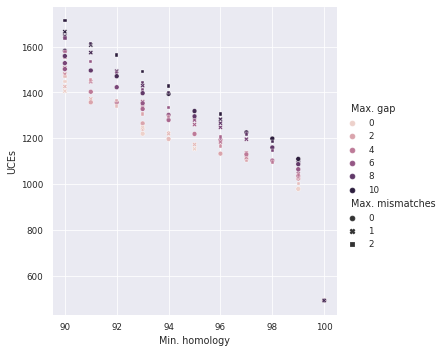

In [9]:
param_uce_plot = sns.relplot(data=parameter_space, x="Min. homology", y="UCEs", hue="Max. gap", style="Max. mismatches")

param_uce_plot.savefig(os.path.join(constants.image_out_dir, "homology_vs_params.pdf"))


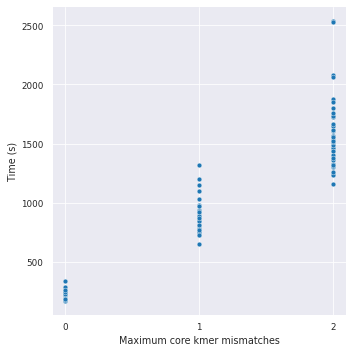

In [14]:
mm_time_p = sns.relplot(data=parameter_space, x="Max. mismatches", y="Time")
mm_time_p.set(xticks=[0,1,2])
mm_time_p.set_axis_labels("Maximum core kmer mismatches", "Time (s)", )
mm_time_p.savefig(os.path.join(constants.image_out_dir, "mm_vs_time.pdf"))
